# Analysis of the result

### Imports

In [69]:
import sys
sys.path.append(r"C:/Users/Matthieu/Documents/_Travail/Stages/Stage M1/Workspace/cooperation_emergence/")

from plot import plot_evolution, plot_histogram, plot_randomized_evolution, \
      plot_hist_by_phenotype, plot_triadic_pattern_phenotype, plot_bar_diadic_pattern, \
      plot_xhi_by_phenotype, plot_diadic_pattern
from analysis import histogram, measure_global, compute_xhi, compute_xhi_mean, compute_all_xhi_mean
from graph import Network
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from dataset import Dataset, measure_frequency_diadic_pattern, measure_global_frequency_triadic_pattern
import os

import pymc as pm
import arviz as az

### Parameters

In [70]:
in_dir = r"../out/RTH_R1_Empty_L10_C750_S75_T0/"
net = Network()
net.reload_with_stack(in_dir)
name = net.name
parameters = net.parameters
oper = net.oper
last_dt = Dataset("local", oper.iter_number)
last_dt.init_with_network(net)
n = parameters["Community size"]
os.makedirs("../plot/" + name + "/", exist_ok=True)

### Analysis

#### Global saturation evolution

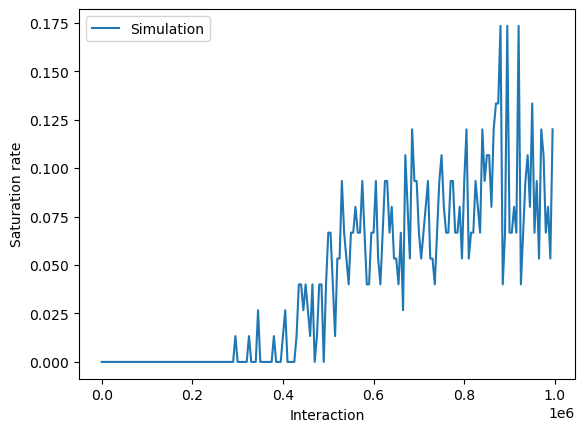

In [71]:
ax = plt.subplot(1, 1, 1)
plot_evolution(ax, "Saturation rate", oper, start=0, end=len(oper), step=5000, parameters=parameters, color="tab:blue", label="Simulation")
plt.legend()
#plt.show()
plt.savefig("../plot/" + name + "/" + "saturation_rate_evolution.png")

#### Global asymmetry rate evolution

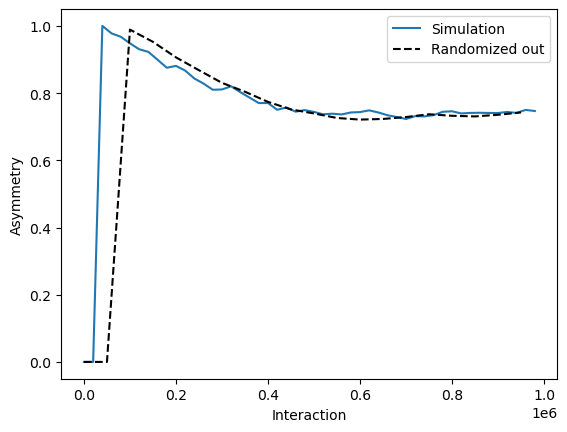

In [72]:
ax = plt.subplot(1, 1, 1)
plot_evolution(ax, "Asymmetry", oper, start=0, end=len(oper), step=20000, parameters=parameters, color="tab:blue", label="Simulation")
plot_randomized_evolution(ax, "Asymmetry", oper, start=0, end=len(oper), step=50000, parameters=parameters, color="k", linestyle="dashed", label="Randomized out")
plt.legend()
#plt.show()
plt.savefig("../plot/"  + name + "/" + "global_asymmetry_evolution.png")

#### Individual asymmetry rate evolution

In [73]:
t, l = oper.resolve(-1)
#random_value = measure_global("Individual asymmetry", t, l, parameters, random=True, niter=25, mode="i&&o", mc_iter=150)

In [74]:
#print("Individual asymmetry rate: ", measure_global("Individual asymmetry", t, l , parameters))
#print("Randomized result: ", random_value)

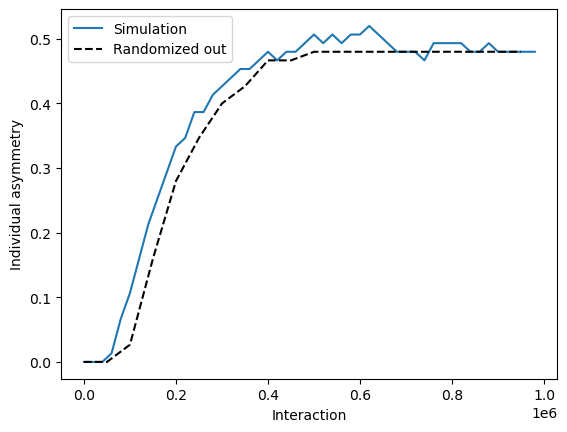

In [75]:
ax = plt.subplot(1, 1, 1)
#ax.hlines(random_value, xmin=0, xmax=len(oper), linestyles="dashed", colors="k", label="Randomized in&out (last)")
plot_evolution(ax, "Individual asymmetry", oper, start=0, end=len(oper), step=20000, parameters=parameters, color="tab:blue", label="Simulation")
plot_randomized_evolution(ax, "Individual asymmetry", oper, start=0, end=len(oper), step=50000, parameters=parameters, color="k", linestyle="dashed", label="Randomized out")
plt.legend()
#plt.show()
plt.savefig("../plot/"  + name + "/" + "individual_asymmetry_evolution.png")

#### State at a specific interaction number

In [76]:
inter = len(oper) # Interaction number at which we want to plot
final_trust, final_link = oper.resolve(inter)
ph_mean = histogram(final_trust, parameters)
mean = ph_mean["Global"]

In [77]:
print("Working with: ", in_dir)
print("Number of interaction: ", inter)
print("Asymmetry rate: ", measure_global("Asymmetry", final_trust, final_link, parameters))
print("Individual asymmetry rate: ", measure_global("Individual asymmetry", final_trust, final_link, parameters))
print("Out preserving ind. asymmetry: ", measure_global("Individual asymmetry", final_trust, final_link, parameters, random=True, niter=1000, mode="o"))
print("Saturation rate: ", measure_global("Saturation rate", final_trust, final_link, parameters))
link_stat = measure_global("Number of link", final_trust, final_link, parameters)
print("Mean number of link per agent: ", link_stat[0])
print("Standard deviation number of link per agent: ", link_stat[1])
print("Mean number of interaction per link: ", 2 * inter / (n * (n-1)))

Working with:  ../out/RTH_R1_Empty_L10_C750_S75_T0/
Number of interaction:  1000000
Asymmetry rate:  0.7541528239202658
Individual asymmetry rate:  0.48
Out preserving ind. asymmetry:  0.48
Saturation rate:  0.02666666666666667
Mean number of link per agent:  30.0
Standard deviation number of link per agent:  20.09975124224178
Mean number of interaction per link:  360.36036036036035


##### Etas and Xhi distribution

In the article of Tamarit *et al.* (2022) the Dunbar's circle are given it term of **cost** which is defined in the context of their resource allocation framework.

This notion can be implemented in our model denoting $s$ as the cost and $t$ the trust value of a link:

$$s_{ij} = t_{ij} - t_{min}$$

where $t_{min}$ is the minimum value of trust for a link to appear 

Estimated eta:  1.592802936330159


<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3644\1199364518.py:13: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi(t)$")


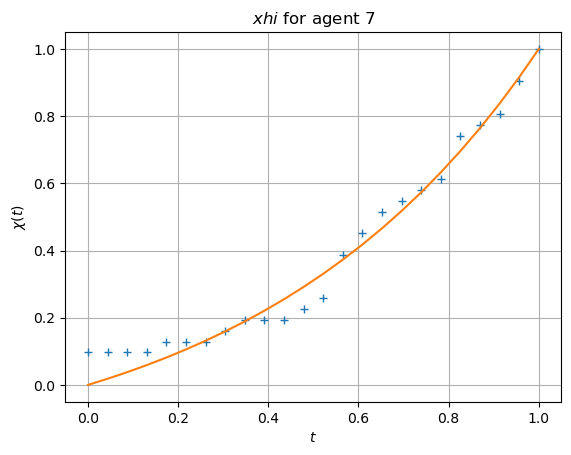

In [78]:
agent = 7

xhi = compute_xhi(agent , final_trust, parameters)
size = xhi.size
t = np.arange(size)
t_norm = t / (size-1)
model = lambda i, eta:  (np.exp(eta * i / (size-1)) - 1) / (np.exp(eta) - 1)
popt, _ = curve_fit(model, np.arange(0, size), xhi)
print("Estimated eta: ", popt[0])
plt.plot(t_norm, xhi, "+", label="data")
plt.plot(t_norm, model(t, popt[0]), label="model")
plt.xlabel("$t$")
plt.ylabel("$\chi(t)$")
plt.title("$xhi$ for agent {}".format(agent))
plt.grid()
#plt.show()
plt.savefig("../plot/" + "Inverse regime.png")

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_3644\957508110.py:12: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi(t)$")


Estimated eta:  5.734095008382044


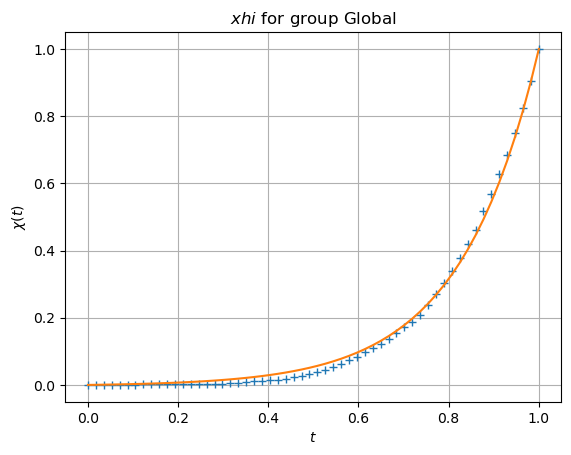

In [79]:
selector = "Global"
xhi_mean = compute_xhi_mean(final_trust, parameters, ph_selector=selector)
size = xhi_mean.size
t = np.arange(size)
t_norm = t/(size-1)
model = lambda i, eta:  (np.exp(eta * i) - 1) / (np.exp(eta) - 1)
popt, _ = curve_fit(model, t_norm, xhi_mean)
print("Estimated eta: ", popt[0])
plt.plot(t_norm, xhi_mean, "+", label="data")
plt.plot(t_norm, model(t_norm, popt[0]), label="model")
plt.xlabel("$t$")
plt.ylabel("$\chi(t)$")
plt.title("$xhi$ for group {}".format(selector))
plt.grid()
plt.show()
#plt.savefig("../plot/" + "Global chi fit.png")


In [80]:
xhi_mean = compute_xhi_mean(final_trust, parameters)
size = xhi_mean.size
t_norm = np.arange(size) / (size-1)
with pm.Model() as model:
    # Priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    etas = pm.Normal("etas", mu=2.5, sigma=4)

    # Likelihood
    likelihood = pm.Normal("xhi mean", mu= (np.exp(etas * t_norm) - 1) / (np.exp(etas) - 1), sigma=sigma, observed=xhi_mean)

    # Inference
    idata = pm.sample(3000, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, etas]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 47 seconds.


In [81]:
az.summary(idata, kind="stats", round_to=4)

,mean,sd,hdi_3%,hdi_97%
etas,5.7342,0.0472,5.6475,5.8251
sigma,0.0125,0.0012,0.0102,0.0147


In [82]:
dta_eta = last_dt.aggregate("Eta")
print(dta_eta.get_item("Eta").get_all_item())

{0: 1.7004255372066337, 1: 3.2312969299984986, 2: 0.9826180990186785, 3: 2.6086100426083676, 4: 3.390062552455739, 5: 3.3666580390559444, 6: 5.023951964191257, 7: 1.5928029461313098, 8: 2.2362161241519662, 9: 2.4937664282510887, 10: 1.8621722619305983, 11: 4.143493311000746, 12: 3.117591538924154, 13: 2.260061250759713, 14: 2.645032082819717, 15: 2.555016153866535, 16: 1.3748811663815559, 17: 1.77726455840218, 18: 1.6934678178622242, 19: 2.9942547592183573, 20: 2.8164081566095147, 21: 5.311752006080906, 22: 2.120245294089227, 23: 2.525862682401238, 24: 2.454235053502847, 25: 4.109554994241163, 26: 1.6624744378545864, 27: 3.248596306864302, 28: 4.707443378500422, 29: 1.3426030249470413, 30: 1.8789539376696198, 31: 1.3138765780699084, 32: 2.5542160715655924, 33: 2.0016364222062832, 34: 3.146888476801053, 35: 6.224244055147464, 36: 3.773186296490209, 37: 1.5371386614867861, 38: 1.5364154596244342, 39: 4.583785818266861, 40: 1.8684120152708912, 41: 2.857866107521797, 42: 1.9379755845658373

##### Etas

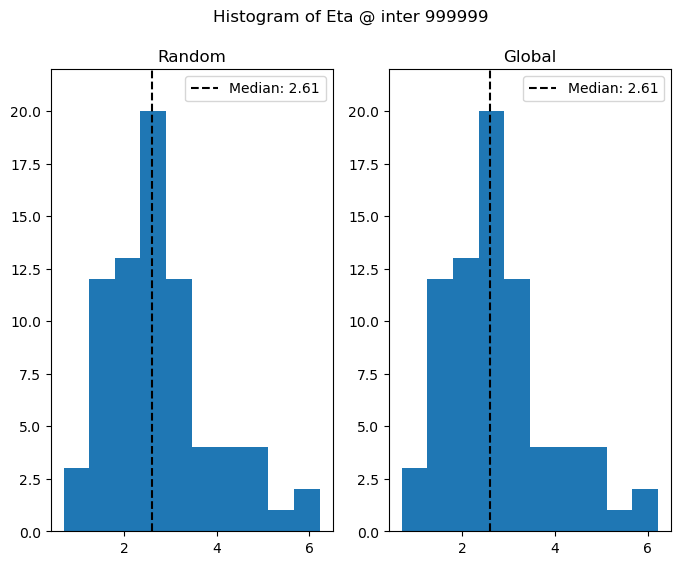

In [83]:
plot_hist_by_phenotype(last_dt, "Eta")
plt.savefig("../plot/"  + name + "/" + "eta_histograms.png")
#plt.show()

##### Xhi by phenotypes

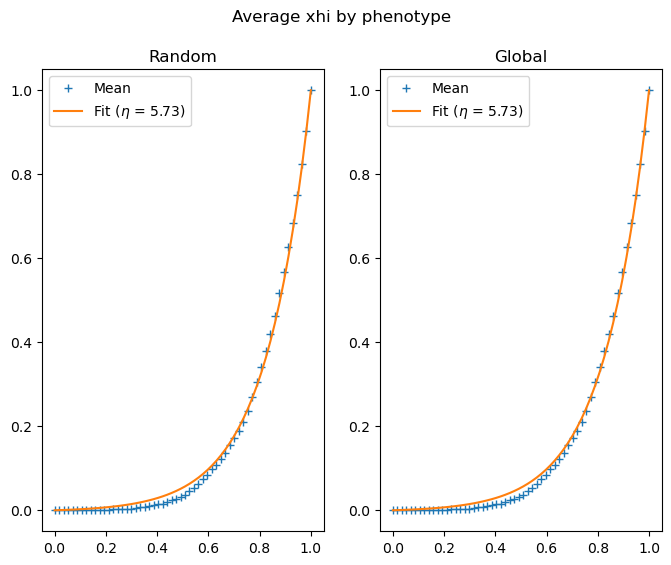

In [84]:
all_xhi = compute_all_xhi_mean(final_trust, parameters)
plot_xhi_by_phenotype(all_xhi)
plt.savefig("../plot/"  + name + "/" + "average_xhi_by_phenotype.png")
#plt.show()

##### Trust Histogram

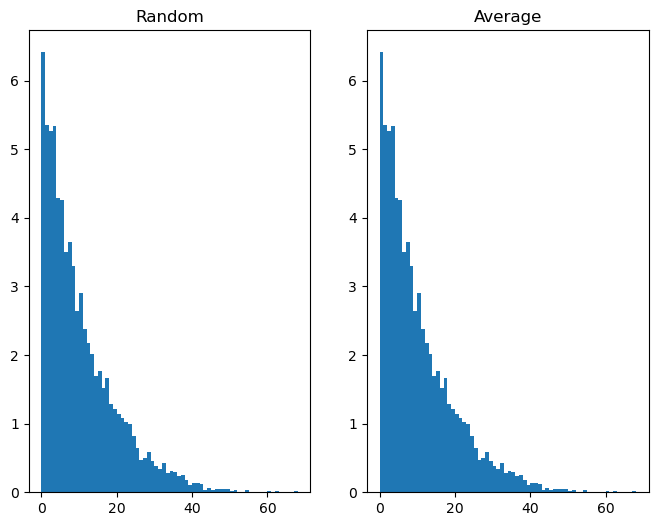

In [85]:
fig, ax = plot_histogram(ph_mean, parameters, log=False, color="tab:blue")
plt.savefig("../plot/" + name + "/" + "trust_histograms" + ".png" )

##### Centrality

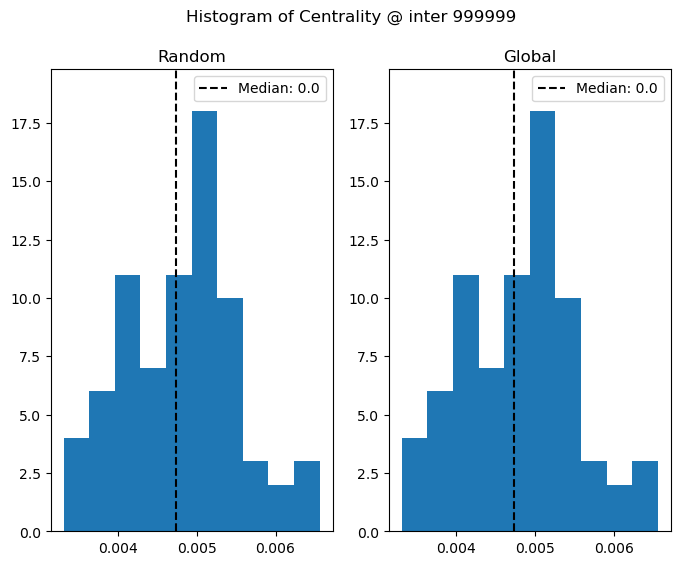

In [86]:
plot_hist_by_phenotype(last_dt, "Centrality")
plt.savefig("../plot/" + name + "/" + "centrality_histograms.png" )
#plt.show()

##### Diadic pattern

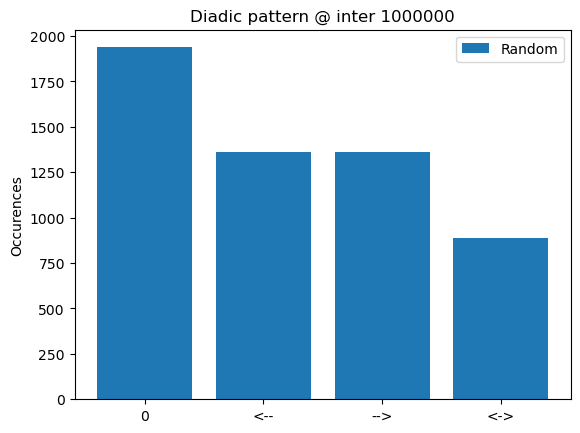

In [ ]:
di_pattern_freq = measure_frequency_diadic_pattern(final_link, net.phenotypes_table, inter)
plot_bar_diadic_pattern(di_pattern_freq)
plt.savefig("../plot/" + name + "/" + "diadic_pattern_bar.png" )
#plt.show()

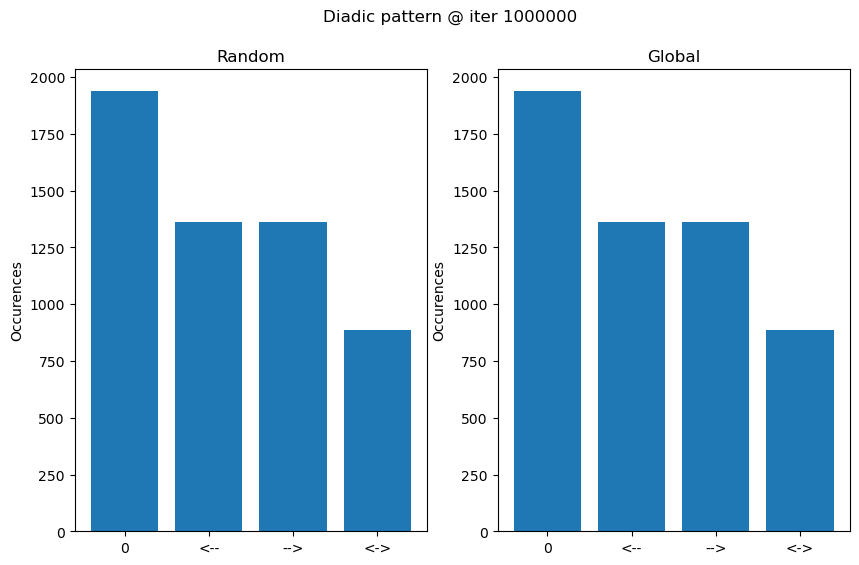

In [ ]:
plot_diadic_pattern(di_pattern_freq)
plt.savefig("../plot/" + name + "/" + "diadic_pattern_phenotype.png" )
#plt.show()

##### Triadic pattern

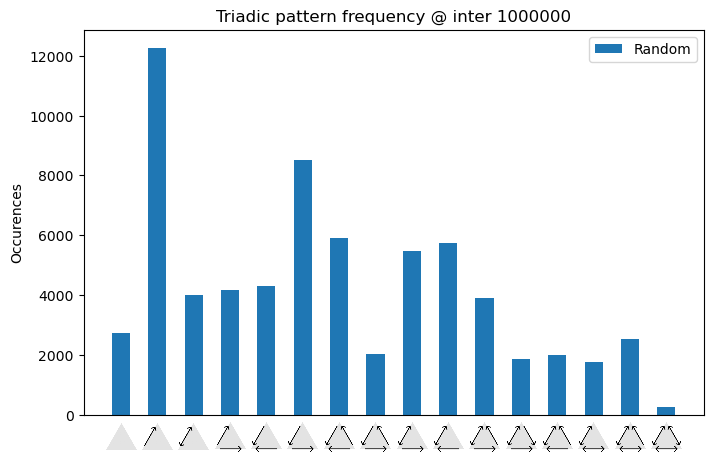

In [89]:
tri_pattern_freq = measure_global_frequency_triadic_pattern(final_link, parameters, inter)
plot_triadic_pattern_phenotype(tri_pattern_freq, parameters)
plt.savefig("../plot/" + name + "/" + "triadic_pattern_bar.png" )
#plt.show()

In [91]:
dtga = tri_pattern_freq.group_by("Transitive").aggregate("Number")
data = dtga.get_item(True).get_item("Number").get_all_item().values()
transitivity_rate = sum(data) / (n * (n-1) * (n-2) / 6)
print(transitivity_rate)

0.24413180303591261
